# NV Center Symmetry Explorer

This notebook provides an interactive exploration of the NV (nitrogen-vacancy) center symmetries in diamond. The NV center has C3v point group symmetry, consisting of:

- **C3 rotations**: 120° and 240° rotations about the NV axis
- **σv mirror planes**: Three vertical mirror planes containing the NV axis
- **Identity operation**: No change

The NV center consists of:
- A nitrogen atom substituting for a carbon atom
- An adjacent vacancy (missing carbon atom)
- Three carbon atoms in tetrahedral arrangement around the vacancy

## Import Required Libraries

First, let's import all the necessary libraries for visualization and interaction.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, HTML
import time

# Configure matplotlib for inline display
%matplotlib inline

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

## NV Center Class Definition

Define the main class that handles the NV center structure and symmetry operations.

In [7]:
class NVCenterNotebook:
    def __init__(self):
        # Initialize NV center coordinates
        self.setup_nv_center()
        
        # Animation parameters
        self.animation_steps = 30
        
        # Create figure and axis
        self.fig = None
        self.ax = None
        
    def setup_nv_center(self):
        """Initialize the NV center atomic positions"""
        # Carbon atoms in tetrahedral arrangement around vacancy
        # Three carbons forming equilateral triangle around the N-V axis
        self.carbon_positions = np.array([
            [1.0, 0.0, 0.0],      # C1
            [-0.5, np.sqrt(3)/2, 0.0],  # C2
            [-0.5, -np.sqrt(3)/2, 0.0]  # C3
        ])
        
        # Nitrogen atom position along [111] direction (NV axis)
        self.nitrogen_position = np.array([0.0, 0.0, 1.0])
        
        # Vacancy position (center)
        self.vacancy_position = np.array([0.0, 0.0, 0.0])
        
        # Current positions for animation
        self.current_carbon = self.carbon_positions.copy()
        self.current_nitrogen = self.nitrogen_position.copy()
        self.current_vacancy = self.vacancy_position.copy()
        
        # Original positions for reset
        self.original_carbon = self.carbon_positions.copy()
        self.original_nitrogen = self.nitrogen_position.copy()
        self.original_vacancy = self.vacancy_position.copy()
        
    def create_plot(self):
        """Create a fresh plot"""
        self.fig = plt.figure(figsize=(12, 10))
        self.ax = self.fig.add_subplot(111, projection='3d')
        return self.fig, self.ax
        
    def plot_nv_center(self, title="NV Center Structure (C3v Symmetry)"):
        """Plot the NV center structure"""
        if self.ax is None:
            self.create_plot()
            
        self.ax.clear()
        
        # Plot carbon atoms
        self.ax.scatter(self.current_carbon[:, 0], self.current_carbon[:, 1], 
                       self.current_carbon[:, 2], c='gray', s=200, alpha=0.8, 
                       label='Carbon')
        
        # Plot nitrogen atom
        self.ax.scatter(self.current_nitrogen[0], self.current_nitrogen[1], 
                       self.current_nitrogen[2], c='blue', s=250, alpha=0.8, 
                       label='Nitrogen')
        
        # Plot vacancy
        self.ax.scatter(self.current_vacancy[0], self.current_vacancy[1], 
                       self.current_vacancy[2], c='red', s=150, alpha=0.6, 
                       marker='o', facecolors='none', edgecolors='red', 
                       linewidth=3, label='Vacancy')
        
        # Draw bonds
        self.draw_bonds()
        
        # Label atoms
        for i, carbon in enumerate(self.current_carbon):
            self.ax.text(carbon[0]+0.1, carbon[1]+0.1, carbon[2]+0.1, 
                        f'C{i+1}', fontsize=10)
        
        self.ax.text(self.current_nitrogen[0]+0.1, self.current_nitrogen[1]+0.1, 
                    self.current_nitrogen[2]+0.1, 'N', fontsize=10, color='blue')
        
        self.ax.text(self.current_vacancy[0]+0.1, self.current_vacancy[1]+0.1, 
                    self.current_vacancy[2]+0.1, 'V', fontsize=10, color='red')
        
        # Set plot properties
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')
        self.ax.set_title(title)
        self.ax.legend()
        
        # Set equal aspect ratio
        max_range = 1.5
        self.ax.set_xlim([-max_range, max_range])
        self.ax.set_ylim([-max_range, max_range])
        self.ax.set_zlim([-0.5, 1.5])
        
        # Set viewing angle
        self.ax.view_init(elev=20, azim=45)
        
        plt.tight_layout()
        
    def draw_bonds(self):
        """Draw bonds between atoms"""
        # Bonds from vacancy to carbon atoms
        for carbon in self.current_carbon:
            self.ax.plot([self.current_vacancy[0], carbon[0]], 
                       [self.current_vacancy[1], carbon[1]], 
                       [self.current_vacancy[2], carbon[2]], 
                       'k-', alpha=0.3, linewidth=1)
        
        # Bond from vacancy to nitrogen
        self.ax.plot([self.current_vacancy[0], self.current_nitrogen[0]], 
                   [self.current_vacancy[1], self.current_nitrogen[1]], 
                   [self.current_vacancy[2], self.current_nitrogen[2]], 
                   'b-', alpha=0.5, linewidth=2)
        
    def rotation_matrix(self, axis, angle):
        """Create rotation matrix for given axis and angle using Rodrigues' formula"""
        axis = axis / np.linalg.norm(axis)
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        
        # Rodrigues' rotation formula
        K = np.array([[0, -axis[2], axis[1]],
                     [axis[2], 0, -axis[0]],
                     [-axis[1], axis[0], 0]])
        
        return np.eye(3) + sin_angle * K + (1 - cos_angle) * np.dot(K, K)
    
    def apply_rotation(self, axis, angle):
        """Apply rotation to the structure"""
        rot_matrix = self.rotation_matrix(axis, angle)
        
        # Apply rotation (N and vacancy stay fixed on the rotation axis)
        self.current_carbon = np.dot(self.original_carbon, rot_matrix.T)
        # Nitrogen and vacancy don't move for C3 rotation about z-axis
        self.current_nitrogen = self.original_nitrogen.copy()
        self.current_vacancy = self.original_vacancy.copy()
        
    def apply_reflection(self, reflection_type):
        """Apply reflection to the structure"""
        if reflection_type == 'v1':
            # Reflection matrix for xz plane (y=0)
            reflection_matrix = np.array([[1, 0, 0],
                                         [0, -1, 0],
                                         [0, 0, 1]])
        elif reflection_type == 'v2':
            # Reflection matrix for plane containing C2 and z-axis
            normal = np.array([np.sqrt(3)/2, 0.5, 0])
            reflection_matrix = np.eye(3) - 2 * np.outer(normal, normal)
        elif reflection_type == 'v3':
            # Reflection matrix for plane containing C3 and z-axis
            normal = np.array([np.sqrt(3)/2, -0.5, 0])
            reflection_matrix = np.eye(3) - 2 * np.outer(normal, normal)
        
        # Apply reflection
        self.current_carbon = np.dot(self.original_carbon, reflection_matrix.T)
        self.current_nitrogen = self.original_nitrogen.copy()
        self.current_vacancy = self.original_vacancy.copy()
        
    def reset_positions(self):
        """Reset to original positions"""
        self.current_carbon = self.original_carbon.copy()
        self.current_nitrogen = self.original_nitrogen.copy()
        self.current_vacancy = self.original_vacancy.copy()

# Create instance
nv_center = NVCenterNotebook()
print("NV Center class initialized successfully!")

NV Center class initialized successfully!


## Initial Structure Visualization

Let's first visualize the initial NV center structure before applying any symmetry operations.

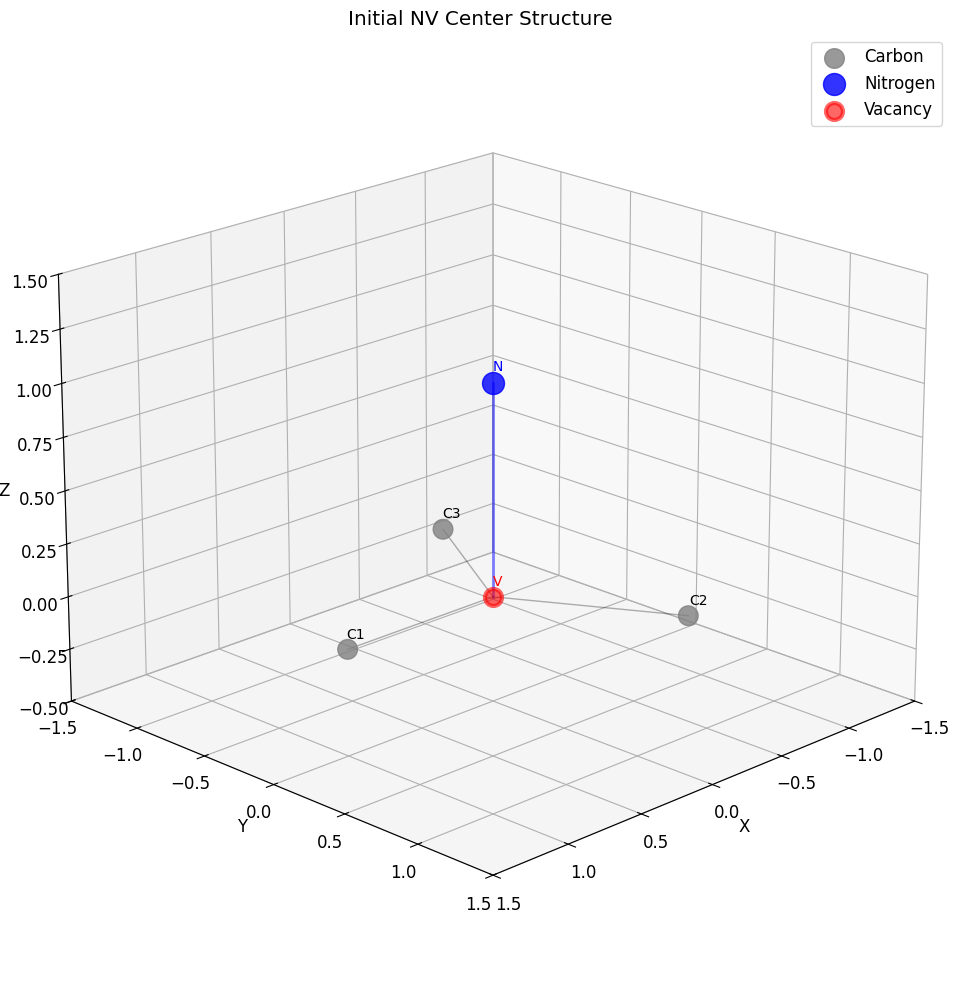


Initial atomic positions:
Nitrogen: [0. 0. 1.]
Vacancy: [0. 0. 0.]
Carbon atoms:
  C1: [1. 0. 0.]
  C2: [-0.5        0.8660254  0.       ]
  C3: [-0.5       -0.8660254  0.       ]


In [8]:
# Plot initial structure
nv_center.create_plot()
nv_center.plot_nv_center("Initial NV Center Structure")
plt.show()

print("\nInitial atomic positions:")
print(f"Nitrogen: {nv_center.nitrogen_position}")
print(f"Vacancy: {nv_center.vacancy_position}")
print(f"Carbon atoms:")
for i, carbon in enumerate(nv_center.carbon_positions):
    print(f"  C{i+1}: {carbon}")

## Interactive Symmetry Operations

Now let's create interactive widgets to explore the different symmetry operations of the NV center.

In [9]:
def update_plot(operation):
    """Update the plot based on selected symmetry operation"""
    nv_center.reset_positions()
    
    if operation == 'Identity':
        title = "Identity Operation (E)"
    elif operation == 'C3 (120°)':
        nv_center.apply_rotation([0, 0, 1], 2*np.pi/3)
        title = "C3 Rotation (120°)"
    elif operation == 'C3² (240°)':
        nv_center.apply_rotation([0, 0, 1], 4*np.pi/3)
        title = "C3² Rotation (240°)"
    elif operation == 'σv1 Mirror':
        nv_center.apply_reflection('v1')
        title = "σv1 Mirror Plane (xz plane)"
    elif operation == 'σv2 Mirror':
        nv_center.apply_reflection('v2')
        title = "σv2 Mirror Plane (containing C2)"
    elif operation == 'σv3 Mirror':
        nv_center.apply_reflection('v3')
        title = "σv3 Mirror Plane (containing C3)"
    
    nv_center.create_plot()
    nv_center.plot_nv_center(title)
    plt.show()

# Create interactive widget
symmetry_operations = ['Identity', 'C3 (120°)', 'C3² (240°)', 'σv1 Mirror', 'σv2 Mirror', 'σv3 Mirror']
operation_widget = widgets.Dropdown(
    options=symmetry_operations,
    value='Identity',
    description='Symmetry Op:',
    style={'description_width': 'initial'}
)

# Create interactive plot
interactive_plot = widgets.interact(update_plot, operation=operation_widget)

print("Use the dropdown menu above to explore different symmetry operations!")

interactive(children=(Dropdown(description='Symmetry Op:', options=('Identity', 'C3 (120°)', 'C3² (240°)', 'σv…

Use the dropdown menu above to explore different symmetry operations!


## Symmetry Analysis

Let's analyze how each symmetry operation affects the carbon atoms' positions.

In [12]:
def analyze_symmetry_operations():
    """Analyze the effect of each symmetry operation on atomic positions"""
    operations = {
        'Identity': lambda: None,
        'C3 (120°)': lambda: nv_center.apply_rotation([0, 0, 1], 2*np.pi/3),
        'C3² (240°)': lambda: nv_center.apply_rotation([0, 0, 1], 4*np.pi/3),
        'σv1 Mirror': lambda: nv_center.apply_reflection('v1'),
        'σv2 Mirror': lambda: nv_center.apply_reflection('v2'),
        'σv3 Mirror': lambda: nv_center.apply_reflection('v3')
    }
    
    print("Symmetry Operation Analysis:")
    print("=" * 50)
    
    original_positions = nv_center.original_carbon.copy()
    
    for op_name, operation in operations.items():
        nv_center.reset_positions()
        if operation:
            operation()
        
        print(f"\n{op_name}:")
        print(f"  Original C1: [{original_positions[0][0]:.3f}, {original_positions[0][1]:.3f}, {original_positions[0][2]:.3f}]")
        print(f"  New C1:      [{nv_center.current_carbon[0][0]:.3f}, {nv_center.current_carbon[0][1]:.3f}, {nv_center.current_carbon[0][2]:.3f}]")
        print(f"  Original C2: [{original_positions[1][0]:.3f}, {original_positions[1][1]:.3f}, {original_positions[1][2]:.3f}]")
        print(f"  New C2:      [{nv_center.current_carbon[1][0]:.3f}, {nv_center.current_carbon[1][1]:.3f}, {nv_center.current_carbon[1][2]:.3f}]")
        print(f"  Original C3: [{original_positions[2][0]:.3f}, {original_positions[2][1]:.3f}, {original_positions[2][2]:.3f}]")
        print(f"  New C3:      [{nv_center.current_carbon[2][0]:.3f}, {nv_center.current_carbon[2][1]:.3f}, {nv_center.current_carbon[2][2]:.3f}]")
        
        # Check which atoms are equivalent after operation
        tolerance = 1e-10
        equivalences = []
        for i in range(3):
            for j in range(3):
                if np.allclose(original_positions[i], nv_center.current_carbon[j], atol=tolerance):
                    equivalences.append(f"C{i+1} → C{j+1}")
        
        print(f"  Atom mapping: {', '.join(equivalences)}")

analyze_symmetry_operations()

Symmetry Operation Analysis:

Identity:
  Original C1: [1.000, 0.000, 0.000]
  New C1:      [1.000, 0.000, 0.000]
  Original C2: [-0.500, 0.866, 0.000]
  New C2:      [-0.500, 0.866, 0.000]
  Original C3: [-0.500, -0.866, 0.000]
  New C3:      [-0.500, -0.866, 0.000]
  Atom mapping: C1 → C1, C2 → C2, C3 → C3

C3 (120°):
  Original C1: [1.000, 0.000, 0.000]
  New C1:      [-0.500, 0.866, 0.000]
  Original C2: [-0.500, 0.866, 0.000]
  New C2:      [-0.500, -0.866, 0.000]
  Original C3: [-0.500, -0.866, 0.000]
  New C3:      [1.000, -0.000, 0.000]
  Atom mapping: C1 → C3, C2 → C1, C3 → C2

C3² (240°):
  Original C1: [1.000, 0.000, 0.000]
  New C1:      [-0.500, -0.866, 0.000]
  Original C2: [-0.500, 0.866, 0.000]
  New C2:      [1.000, -0.000, 0.000]
  Original C3: [-0.500, -0.866, 0.000]
  New C3:      [-0.500, 0.866, 0.000]
  Atom mapping: C1 → C2, C2 → C3, C3 → C1

σv1 Mirror:
  Original C1: [1.000, 0.000, 0.000]
  New C1:      [1.000, 0.000, 0.000]
  Original C2: [-0.500, 0.866, 0.000

## Character Table for C3v Point Group

Let's create and display the character table for the C3v point group.

In [10]:
import pandas as pd

# Create character table for C3v point group
character_table = pd.DataFrame({
    'Irrep': ['A1', 'A2', 'E'],
    'E': [1, 1, 2],
    '2C3': [1, 1, -1],
    '3σv': [1, -1, 0],
    'Linear/Rotational': ['z', 'Rz', '(x,y), (Rx,Ry)'],
    'Quadratic': ['z²', '', '(x²-y², xy), (xz, yz)']
})

print("Character Table for C3v Point Group:")
print("=" * 60)
display(character_table)

print("\nExplanation:")
print("- A1: Totally symmetric representation")
print("- A2: Symmetric to rotations, antisymmetric to reflections")
print("- E: Doubly degenerate representation")
print("- The NV center's electronic states transform according to these irreducible representations")

Character Table for C3v Point Group:


,Irrep,E,2C3,3σv,Linear/Rotational,Quadratic
0,A1,1,1,1,z,z²
1,A2,1,1,-1,Rz,
2,E,2,-1,0,"(x,y), (Rx,Ry)","(x²-y², xy), (xz, yz)"



Explanation:
- A1: Totally symmetric representation
- A2: Symmetric to rotations, antisymmetric to reflections
- E: Doubly degenerate representation
- The NV center's electronic states transform according to these irreducible representations


## Summary

This notebook demonstrates the NV center symmetry operations that you can explore interactively using the dropdown widget above.

In [ ]:
print("NV Center Symmetry Operations Available:")
print("=" * 45)

print("\n1. Identity (E): No change")
print("2. C3 rotation: 120° rotation about NV axis")
print("3. C3² rotation: 240° rotation about NV axis")
print("4. σv1 mirror: Reflection through xz plane")
print("5. σv2 mirror: Reflection through plane containing C2")
print("6. σv3 mirror: Reflection through plane containing C3")

print("\n" + "=" * 45)
print("Use the dropdown widget above to explore different symmetry operations!")
print("The symmetry analysis shows how each operation affects the atomic positions.")

NV Center Symmetry Summary:

1. Point Group: C3v
   - 3-fold rotation axis along N-V direction
   - 3 mirror planes containing the N-V axis
   - Total of 6 symmetry operations (including identity)

2. Atomic Structure:
   - Nitrogen atom substitutes for carbon
   - Adjacent vacancy creates the defect
   - Three carbon atoms maintain tetrahedral coordination

3. Electronic Properties:
   - Ground state: ³A₂ (spin triplet)
   - Excited state: ³E (doubly degenerate)
   - Zero-field splitting: D = 2.87 GHz
   - Optical transitions: ~637 nm (red light)

4. Applications:
   - Quantum sensing (magnetometry, thermometry)
   - Quantum computing (qubit operations)
   - Single-photon sources
   - Biological imaging

5. Symmetry Operations Demonstrated:
   1. Identity (E): No change
   2. C3 rotation: 120° rotation about NV axis
   3. C3² rotation: 240° rotation about NV axis
   4. σv1 mirror: Reflection through xz plane
   5. σv2 mirror: Reflection through plane containing C2
   6. σv3 mirror: Re